In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from CustomClassesLRP3D import *
from ufuncs import *


import seaborn as sns
sns.set_style('whitegrid')

In [3]:
# this code is adapted to cuda tensors, if run on cpu one needs to make small adjustments
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Load data

In [3]:
train_data = np.load('data/lrp_3d_data/train_data.npy')
test_data = np.load('data/lrp_3d_data/test_data.npy')

k = np.arange(-0.4, 0.405, 0.005)
N_kappas = test_data.shape[0]

print('test data shape :',test_data.shape)
print('train data shape:',train_data.shape)



test data shape : (161, 100, 16, 16, 16)
train data shape: (161, 200, 16, 16, 16)


In [4]:
# turn labels into one-hot vectors with gaus smearing
sigma = 3 * 0.005
k_gaus = np.zeros((N_kappas, N_kappas))
for i, k_true in enumerate(k):
    k_gaus[i] = np.exp( -(k-k_true)**2/(2*sigma**2) ) 

k_gaus = np.round(k_gaus, 12)

# shuffle data into batches and allocate to cuda memory
train, train_labels = shuffle_data_3d(train_data, k_gaus, batchsize = 40)                   # function in ufuncs.py
test , test_labels  = shuffle_data_3d(test_data  ,k_gaus, batchsize = 100, shuffle=False)

print('train data shape:', train.shape)
print('test data shape :', test.shape,'\n')

print('train labels shape:',  train_labels.shape)
print('test labels shape :',  test_labels.shape)

#free memory 
del test_data
del train_data

train data shape: torch.Size([805, 40, 16, 16, 16])
test data shape : torch.Size([161, 100, 16, 16, 16]) 

train labels shape: torch.Size([805, 40, 161])
test labels shape : torch.Size([161, 100, 161])


# Train model

In [17]:
# model = torch.load('models/lrp_3d/model_1.pt')
model = CNN_Classification(np.array([N_kappas]), n_filters = 4, n_dense_nodes = 2048)
print(model)

CNN_Classification(
  (conv): _Conv3dBlock(
    (conv): Sequential(
      (0): FirstConv3d(1, 4, kernel_size=(2, 2, 2), stride=(1, 1, 1), bias=False)
      (1): CustomReLU()
      (2): CustomMaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (dense): Sequential(
    (0): NextLinear(in_features=2048, out_features=512, bias=True)
    (1): CustomReLU()
    (2): NextLinear(in_features=512, out_features=161, bias=True)
    (3): CustomLeakyReLU(negative_slope=0.01)
  )
)


In [9]:
#define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
#train
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(train, train_labels, model, criterion, optimizer, lasso=True, factor=0.002)
    test_loop(test, test_labels, model, criterion)
print("Done!")

Epoch 1
Avg test loss:  0.005267 

Done!


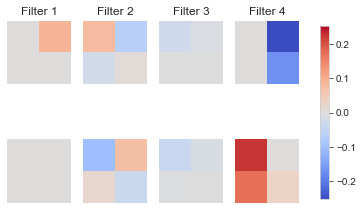

In [11]:
#plot filters in 2d. 3d plot code is found in ....
filters = model.conv.conv[0].weight.squeeze(1).detach().cpu().numpy()


vmax = np.max(np.abs((filters)))
i=0
fig, axes = plt.subplots(nrows=2, ncols=4)

for i, ax in enumerate(axes[0]):
    ax.set_title('Filter {}'.format(1+i))
    im = ax.imshow(filters[i,0], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    ax.axis('off')
    
for i, ax in enumerate(axes[1]):
    im = ax.imshow(filters[i,1], vmin=-vmax, vmax=vmax, cmap='coolwarm')
    ax.axis('off')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)

saveplot = False                                        # set to true if plots should be saved
if saveplot: plt.savefig('models/lrp3D/filters.png')
plt.show()

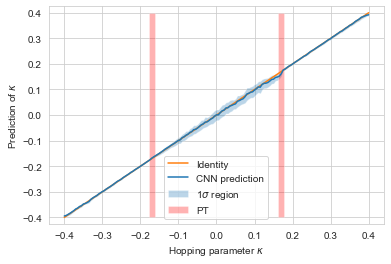

In [12]:
# plot predictions
preds, sigmas = predict(test, model, k)

plt.plot([k[0], k[-1]], [k[0], k[-1]], label='Identity', color = 'C1')
plt.plot(k, preds, label = 'CNN prediction')
plt.fill_between(k, preds+sigmas, preds-sigmas, alpha = 0.3, label = r'1$\sigma$ region' )

plt.ylabel(r'Prediction of $\kappa$')
plt.xlabel(r'Hopping parameter $\kappa$')

plt.bar([-0.17, 0.17], height = k[-1]- k[0] , bottom = k[0], width = 0.015, color = 'r', alpha = 0.3, label='PT')
plt.legend()
plt.ylim([-0.425, 0.425])
if saveplot: plt.savefig('models/lrp3D/preds')

In [13]:
# get relevances for each filter
relevances = []
for i, batch in enumerate(test):
    x = model(batch.unsqueeze(1))
    rel = model.relprop(x.cpu().detach().numpy(), layer_stop=3)
    rel = rel.reshape(100,4,512)
    relevances.append(np.mean(np.sum(rel, axis=2), axis = 0))
   
relevances = np.array(relevances).T
print(relevances.shape)

(4, 161)


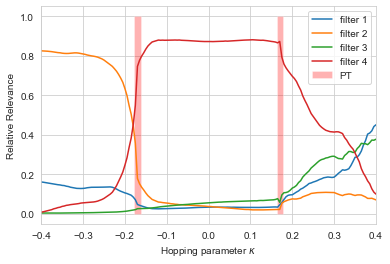

In [16]:
# plot relevances
total_rel = np.sum(relevances, axis = 0)
plt.figure()

for i in range(4):
    plt.plot(k, relevances[i]/total_rel, alpha =1, label = f'filter {i+1}')

plt.ylabel('Relative Relevance')
plt.xlabel(r'Hopping parameter $\kappa$')

#plt.plot(k, (relevances[1]+relevances[2])/total_rel, linestyle='--', color ='grey', label='filter 2+3')
plt.bar([-0.17, 0.17], height = 1 , bottom = -0., width = 0.015, color = 'r', alpha = 0.3, label='PT')
plt.legend()
plt.ylim([-0.05, 1.05])
plt.xlim([-0.4, 0.4])

if saveplot:plt.savefig('models/lrp3D/relevances_relative')
plt.show()


In [21]:
#torch.save(model, 'models/lrp_3d/model.pt')